In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K 
import tensorflow as tf

In [2]:
#General variables

simple = True
train_amount = 0.75
filters = 16
classes = 3

#1 Importando Dataset

In [3]:
#Data
import numpy as np
import os
import cv2
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
if simple:
  if not os.path.isdir("./datasets/tomo_img/mask"):
    #!unzip data.zip
    next


  input_path = os.listdir("./datasets/tomo_img/img/")
  masks = []
  imgs = []
  for file in input_path:
      img_path = os.path.join("./datasets/tomo_img/img/", file)
      mask_path = os.path.join("./datasets/tomo_img/mask/", file)
      img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
      mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
      #img = cv2.resize(img, (512, 512))
      #mask = cv2.resize(mask, (512, 512))
      imgs.append(img)
      masks.append(mask)
      print(len(imgs))
  
  imgs = np.stack(imgs, axis = 0)
  masks = np.stack(masks, axis = 0)
  total_samples = imgs.shape[0]
  toTrain = int(train_amount * total_samples)
  X = imgs[:toTrain,:,:]
  X_val = imgs[toTrain:,:,:]
  y = masks[:toTrain,:,:]
  y_val = masks[toTrain:,:,:]

else:
  import nibabel as nib

  datasets_path = "./datasets/tomo"
  imgs_path = os.path.join(datasets_path, "img/volume_pt1")
  masks_path = os.path.join(datasets_path, "mask")

  volumes_num = 1
  total_volumes = volumes_num*2


  images_path = [f"{imgs_path}/volume-{i}.nii" for i in range(total_volumes)]
  masks_path = [f"{masks_path}/segmentation-{i}.nii" for i in range(total_volumes)]
  imgs = []
  masks = []
  for file in images_path:
      img = nib.load(file).get_fdata()
      for i in range(img.shape[2]):
          imgs.append(img[:,:,i])
  imgs = np.array(imgs)


  for file in masks_path:
      img = nib.load(file).get_fdata()
      for i in range(img.shape[2]):
          masks.append(img[:,:,i])
  masks = np.array(masks)
  print(masks.shape)

  total_samples = imgs.shape[0]
  print(total_samples)
  toTrain = int(train_amount * total_samples)
  toVal = total_samples - toTrain

  X = imgs[:toTrain,:,:]
  X_val = imgs[toTrain:,:,:]
  y = masks[:toTrain,:,:]
  y_val = masks[toTrain:,:,:]

print(X.shape, X_val.shape, y.shape, y_val.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


MemoryError: Unable to allocate 4.51 GiB for an array with shape (18479, 512, 512) and data type uint8

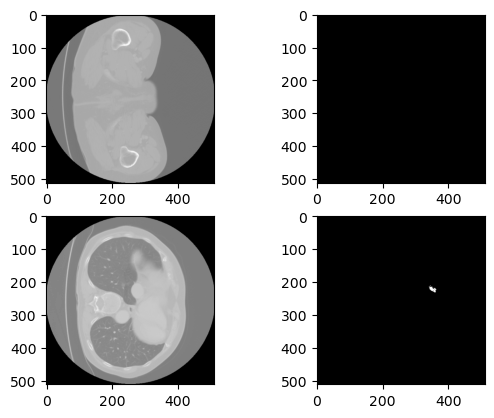

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
id = 0
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X[id], cmap = 'gray')
axarr[0,1].imshow(y[id,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[id], cmap = 'gray')
axarr[1,1].imshow(y_val[id,:,:], cmap = 'gray')

plt.show()

#2 Criando a arquitetura

In [ ]:
#Definindo dice coeficiente
def dice_coefficient(y_true, y_pred, smooth=1):
    num_classes = K.int_shape(y_pred)[-1]
    dice = 0
    for index in range(num_classes):    
        y_true_class = y_true[..., index]
        y_pred_class = y_pred[..., index]
        y_true_class = K.cast(y_true_class, dtype='float32')  # Convert y_true to float32
        intersection = K.sum(K.abs(y_true_class * y_pred_class), axis=-1)
        union = K.sum(y_true_class, axis=-1) + K.sum(y_pred_class, axis=-1)
        dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [ ]:
input = Input((512, 512,1))

conv1 = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(input)
# Including batch normalization as possible fix to all black prediction
conv1 = BatchNormalization()(conv1)
conv1_ = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

pool1.shape

TensorShape([None, 256, 256, 32])

In [ ]:
current = y_val[0]

In [ ]:
current = K.flatten(current)
current.shape
for i in current:
    if i:
        print(i)

tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(2.0, shape=(), dtype=float64)


In [ ]:
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

pool2.shape

TensorShape([None, 128, 128, 64])

In [ ]:
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

pool3.shape

TensorShape([None, 64, 64, 128])

In [ ]:
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv4)
conv4 = BatchNormalization()(conv4)
#drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

pool4.shape

TensorShape([None, 32, 32, 256])

In [ ]:
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
conv5 = BatchNormalization()(conv5)
#drop5 = Dropout(0.5)(conv5)

conv5.shape

TensorShape([None, 32, 32, 512])

In [ ]:
convUp = Conv2DTranspose(filters*16, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
convUp = Concatenate()([convUp, conv4])
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 64, 64, 256])

In [ ]:
convUp = Conv2DTranspose(filters*8, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv3])
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 128, 128, 128])

In [ ]:
convUp = Conv2DTranspose(filters*4, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv2])
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 256, 256, 64])

In [ ]:
convUp = Conv2DTranspose(filters*2, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv1])
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 512, 512, 32])

In [ ]:
if classes == 2:
    output = Conv2D(1, (1,1), activation = 'sigmoid', kernel_initializer = 'he_uniform')(convUp)
else:
    output = Conv2D((classes), (1,1), activation = 'softmax', kernel_initializer = 'he_uniform')(convUp)
output.shape

model = Model(inputs = [input], outputs = [output])
#Using only dice
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = [dice_loss],
              metrics = [dice_coefficient])
model.summary()
output.shape

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 512, 512, 32  320         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 512, 512, 32  128        ['conv2d_95[0][0]']              
 ormalization)                  )                                                           

TensorShape([None, 512, 512, 3])

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#3 Treinando a rede

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', save_freq = 'epoch')
#model.load_weights("model.h5")
history = model.fit(X, y, epochs=50, batch_size = 8, callbacks = [checkpoint], validation_data=(X_val, y_val))

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/dice_loss/mul_4/BroadcastGradientArgs' defined at (most recent call last):
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_9636/1985925230.py", line 3, in <module>
      history = model.fit(X, y, epochs=50, batch_size = 8, callbacks = [checkpoint], validation_data=(X_val, y_val))
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/lasse-409/anaconda3/envs/tensorflow2/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/dice_loss/mul_4/BroadcastGradientArgs'
Incompatible shapes: [8,512] vs. [8,512,512]
	 [[{{node gradient_tape/dice_loss/mul_4/BroadcastGradientArgs}}]] [Op:__inference_train_function_192609]

#4 Testes

In [ ]:
#model = tf.keras.models.load_model('model.31.h5')
a = X_val[0:10]
test = model.predict(a)
#X_val.shape

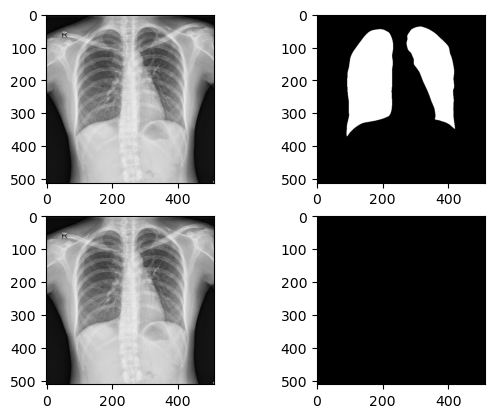

In [ ]:
image_id = 7

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_val[image_id], cmap = 'gray')
axarr[0,1].imshow(y_val[image_id,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[image_id], cmap = 'gray')
axarr[1,1].imshow(test[image_id,:,:], cmap = 'gray')

plt.show()

In [ ]:
import pickle


with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)